# **Prediction Of Stock Price using RNN**
For this task, the dataset “Daily Historical Stock Prices (1970 - 2018)” was taken from Kaggle. This dataset contains stock prices for several thousand unique stock quotes.

Since there are a lot of quotes, it was decided to choose AAPL. The number of records is 9507 for each feature.

**The dataset contains:**
1. Ticker - stock quotes (abbreviation)
2. Open - the price at the start of trading on a particular day 
3. Close - the price at the end of trading on a particular day
4. Adj_close - "adjusted" closing price, that means that all actions with stocks that could have been performed before the opening of the next trading day were added to the closing price of the period.
5. Low - the lowest price on a particular day
6. High - the highest price on a particular day
7. Volume - the number of stocks with which transactions were made on the trading day
8. Date - the date of the year-month-day format.

For this task, the case was considered when there are several parallel time series, and the value must be predicted for each series. In other words, prediction was performed for each of the 5 features for the next time step. This prediction is called multidimensional.

In [ ]:
# Installing kaggle to load the dataset 
!pip install kaggle

In [ ]:
# Connection to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
# Change the working directory to Google Drive. 
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
# Loading dataset from Kaggle
!kaggle datasets download -d ehallmar/daily-historical-stock-prices-1970-2018

In [ ]:
# Unzipping and removing the archive 
!unzip \*.zip  && rm *.zip

In [ ]:
#Import the required libraries
!pip install -U keras-tuner
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from kerastuner import Objective

     |████████████████████████████████| 61kB 1.3MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=f4312e881d5fc164b64f4a6523965010b9d62c0c4030778a67fc581c3bb2ed80
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=5d51a7debc93d57ce2ed3c267ea15e0d6c67e52f89ba433c6b65fb36babcd945
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
missing_values = ["n/a", "na", "--"] # array of possible missing and null values
df_old = pd.read_csv('./historical_stock_prices.csv', na_values = missing_values) # loading dataset using pandas 
df = df_old.loc[(df_old['ticker']=='AAPL')] # choosing only AAPL stock
date_time = df['date'] # saving dates
df = df.drop(['ticker', 'date', 'volume'], axis=1) # removing unnecessary columns

In [ ]:
# Checking for missing and null values in a dataset
df_old.isnull().values.any()

False

In [ ]:
df_old.head() # showing the first 5 rows of the dataset

,ticker,open,close,adj_close,low,high,volume,date
0,AHH,11.50,11.58,8.493155,11.25,11.68,4633900,2013-05-08
1,AHH,11.66,11.55,8.471151,11.50,11.66,275800,2013-05-09
2,AHH,11.55,11.60,8.507822,11.50,11.60,277100,2013-05-10
3,AHH,11.63,11.65,8.544494,11.55,11.65,147400,2013-05-13
4,AHH,11.60,11.53,8.456484,11.50,11.60,184100,2013-05-14


In [ ]:
# showing the basic statistical characteristics of the data for each numerical characteristic for analyzing the possible presence of conflicting data. 
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open,9507.0,24.687907,43.895625,0.198661,1.044643,1.651786,24.447144,218.100006
close,9507.0,24.687426,43.906561,0.196429,1.044643,1.654018,24.300714,217.580002
adj_close,9507.0,21.123911,41.743771,0.008871,0.145975,0.871499,16.330062,217.580002
low,9507.0,24.441421,43.540175,0.196429,1.025714,1.620536,24.013572,215.110001
high,9507.0,24.921086,44.249041,0.198661,1.066429,1.681429,24.767858,219.179993


In [ ]:
# Data scaling
# (so that the convergence of the neural network will be faster
# and one significant number in the data does not affect the model only because of its large value)
sc = MinMaxScaler()
df_norm = sc.fit_transform(df)

In [ ]:
# Splitting the data into training and test
n = len(df)
train_df = df_norm[0:int(n*0.9)]
test_df = df_norm[int(n*0.9):]

In [ ]:
# Splitting a multidimensional sequence
# (it splits a given multidimensional sequence into multiple samples for each feature,
# where each sample has a given number of time steps (60 days in this case) and the output is a single time step)  
def split_sequences(sequences, n_steps_back):
  X, y = [], []
  for i in range(n_steps_back, len(sequences)):
      X.append(sequences[i-n_steps_back : i, :])
      y.append(sequences[i, :])
  return np.array(X), np.array(y)

In [ ]:
num_steps_back = 60 # time step: 60 days 
num_features = len(df.columns) # number of features
X, y = split_sequences(train_df, num_steps_back) # training X и Y data
test_X, test_Y = split_sequences(test_df, num_steps_back) # test X и Y data

In [ ]:
# Building a Model for Hyperparameter tuning
def build_model(hp):
    model = Sequential() 
    model.add(LSTM(units=hp.Int('layer_input',
                                   min_value=32,
                                   max_value=256,
                                   step=32),
                   return_sequences=True,
                   input_shape=(num_steps_back, num_features)))
    model.add(LSTM(units=hp.Int('layer_output',
                                   min_value=32,
                                   max_value=256,
                                   step=32),
                   input_shape=(num_steps_back, num_features)))
    model.add(Dense(num_features))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
# Removing previously created files for next tuner launches. 
!rm './untitled_project/oracle.json'
!rm './untitled_project/tuner0.json'

In [ ]:
# Setting up a Random Search that randomly selects hyperparameters
tuner = RandomSearch(
    build_model,                 # function of building the model
    Objective('val_loss',direction='min'),    # metric for optimization 
    max_trials=64,               # maximum number of training iterations
    )
tuner.search_space_summary()

In [ ]:
# Using the EarlyStopping to prevent overfitting 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
callbacks_list = [es]

# Launching the tuner
tuner.search(X,                  # Training data
             y,                  # Y of training data
             epochs=7,                # Number of epochs
             validation_split=0.1, # Validation data - the 0.1 of the training data
             callbacks=callbacks_list
             )

Epoch 1/7
239/239 [==============================] - 3s 14ms/step - loss: 4.2554e-05 - val_loss: 8.0809e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 8.5467e-06 - val_loss: 7.3778e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 8.2406e-06 - val_loss: 4.1075e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 5.7154e-06 - val_loss: 4.4967e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 5.2108e-06 - val_loss: 4.3403e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 5.6993e-06 - val_loss: 4.4620e-04
Epoch 00006: early stopping


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 3.9011e-05 - val_loss: 8.0792e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 7.3341e-06 - val_loss: 0.0010
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 6.1372e-06 - val_loss: 5.2742e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 4.9115e-06 - val_loss: 5.9618e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 4.8257e-06 - val_loss: 5.2590e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 5.2711e-06 - val_loss: 4.5299e-04
Epoch 7/7
239/239 [==============================] - 3s 11ms/step - loss: 3.8571e-06 - val_loss: 4.0508e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 4.9218e-05 - val_loss: 0.0013
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 7.5113e-06 - val_loss: 5.5084e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 7.4086e-06 - val_loss: 6.7201e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 5.7333e-06 - val_loss: 5.0156e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 5.6051e-06 - val_loss: 4.3150e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 4.8222e-06 - val_loss: 3.8485e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 4.8186e-06 - val_loss: 3.6651e-04


Epoch 1/7
239/239 [==============================] - 3s 14ms/step - loss: 4.1497e-05 - val_loss: 6.5070e-04
Epoch 2/7
239/239 [==============================] - 3s 11ms/step - loss: 8.6172e-06 - val_loss: 4.6175e-04
Epoch 3/7
239/239 [==============================] - 3s 11ms/step - loss: 6.8364e-06 - val_loss: 5.5965e-04
Epoch 4/7
239/239 [==============================] - 3s 11ms/step - loss: 4.6789e-06 - val_loss: 3.1280e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 4.2074e-06 - val_loss: 3.4504e-04
Epoch 6/7
239/239 [==============================] - 3s 11ms/step - loss: 5.0995e-06 - val_loss: 3.0710e-04
Epoch 7/7
239/239 [==============================] - 3s 11ms/step - loss: 4.2129e-06 - val_loss: 3.0583e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 4.4565e-05 - val_loss: 7.2728e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 8.2443e-06 - val_loss: 6.5602e-04
Epoch 3/7
239/239 [==============================] - 3s 11ms/step - loss: 6.5734e-06 - val_loss: 4.5344e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 5.5259e-06 - val_loss: 5.2581e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 5.1263e-06 - val_loss: 3.6345e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 6.3430e-06 - val_loss: 6.5316e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 4.5267e-06 - val_loss: 4.0848e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 4.9762e-05 - val_loss: 9.2663e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 7.6454e-06 - val_loss: 6.5965e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 6.2914e-06 - val_loss: 4.6856e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 6.2776e-06 - val_loss: 4.9752e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 5.6693e-06 - val_loss: 4.4854e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 4.3199e-06 - val_loss: 3.3987e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 4.3474e-06 - val_loss: 6.0293e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 3.6449e-05 - val_loss: 8.8763e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 8.0258e-06 - val_loss: 6.2205e-04
Epoch 3/7
239/239 [==============================] - 3s 11ms/step - loss: 6.6700e-06 - val_loss: 4.6441e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 5.6579e-06 - val_loss: 3.2997e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 5.0795e-06 - val_loss: 5.4474e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 4.5750e-06 - val_loss: 6.3399e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 4.6687e-06 - val_loss: 3.6109e-04
Epoch 00007: early stopping


Epoch 1/7
239/239 [==============================] - 3s 14ms/step - loss: 2.4979e-05 - val_loss: 5.8664e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 8.6400e-06 - val_loss: 4.4135e-04
Epoch 3/7
239/239 [==============================] - 3s 11ms/step - loss: 5.6713e-06 - val_loss: 4.1504e-04
Epoch 4/7
239/239 [==============================] - 3s 11ms/step - loss: 5.1947e-06 - val_loss: 3.8163e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 5.7590e-06 - val_loss: 4.2860e-04
Epoch 6/7
239/239 [==============================] - 3s 11ms/step - loss: 4.4918e-06 - val_loss: 2.7197e-04
Epoch 7/7
239/239 [==============================] - 3s 10ms/step - loss: 3.5323e-06 - val_loss: 1.6608e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 3.5794e-05 - val_loss: 7.5959e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 6.9500e-06 - val_loss: 7.9884e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 5.9452e-06 - val_loss: 5.0552e-04
Epoch 4/7
239/239 [==============================] - 3s 11ms/step - loss: 5.7333e-06 - val_loss: 3.1043e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 4.9725e-06 - val_loss: 3.2009e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 4.0684e-06 - val_loss: 3.5295e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 5.4989e-06 - val_loss: 5.5043e-04
Epoch 00007: early stopping


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 5.2104e-05 - val_loss: 5.8854e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 7.1719e-06 - val_loss: 5.9268e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 7.6735e-06 - val_loss: 6.5441e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 5.7016e-06 - val_loss: 5.5479e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 6.1267e-06 - val_loss: 3.9672e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 5.1810e-06 - val_loss: 6.2502e-04
Epoch 7/7
239/239 [==============================] - 3s 10ms/step - loss: 4.7549e-06 - val_loss: 3.8007e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 3.8774e-05 - val_loss: 6.8931e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 7.7824e-06 - val_loss: 6.7741e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 8.6364e-06 - val_loss: 5.2902e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 4.6895e-06 - val_loss: 3.9558e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 4.3719e-06 - val_loss: 4.5936e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 5.4665e-06 - val_loss: 4.4144e-04
Epoch 7/7
239/239 [==============================] - 3s 12ms/step - loss: 4.2476e-06 - val_loss: 2.9019e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 5.8283e-05 - val_loss: 6.8078e-04
Epoch 2/7
239/239 [==============================] - 3s 10ms/step - loss: 7.3160e-06 - val_loss: 7.9565e-04
Epoch 3/7
239/239 [==============================] - 3s 11ms/step - loss: 6.2551e-06 - val_loss: 4.3624e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 7.2849e-06 - val_loss: 6.5789e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 5.3675e-06 - val_loss: 4.1737e-04
Epoch 6/7
239/239 [==============================] - 3s 11ms/step - loss: 4.6376e-06 - val_loss: 3.6242e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 5.0343e-06 - val_loss: 3.5256e-04


Epoch 1/7
239/239 [==============================] - 3s 14ms/step - loss: 3.3755e-05 - val_loss: 0.0014
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 7.2883e-06 - val_loss: 6.8535e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 5.9362e-06 - val_loss: 6.1235e-04
Epoch 4/7
239/239 [==============================] - 3s 10ms/step - loss: 6.3650e-06 - val_loss: 5.2119e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 6.2139e-06 - val_loss: 3.8521e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 3.9579e-06 - val_loss: 2.2514e-04
Epoch 7/7
239/239 [==============================] - 3s 11ms/step - loss: 3.7593e-06 - val_loss: 2.0364e-04


Epoch 1/7
239/239 [==============================] - 3s 12ms/step - loss: 6.0544e-05 - val_loss: 0.0012
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 7.1120e-06 - val_loss: 9.2911e-04
Epoch 3/7
239/239 [==============================] - 2s 9ms/step - loss: 6.6503e-06 - val_loss: 0.0010
Epoch 4/7
239/239 [==============================] - 2s 9ms/step - loss: 6.2772e-06 - val_loss: 0.0011
Epoch 5/7
239/239 [==============================] - 2s 9ms/step - loss: 5.7582e-06 - val_loss: 6.8368e-04
Epoch 6/7
239/239 [==============================] - 2s 9ms/step - loss: 6.3176e-06 - val_loss: 9.5464e-04
Epoch 7/7
239/239 [==============================] - 2s 9ms/step - loss: 5.4744e-06 - val_loss: 4.3772e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 2.8822e-05 - val_loss: 7.1941e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 7.0735e-06 - val_loss: 5.9726e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 5.5853e-06 - val_loss: 3.8761e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 4.9927e-06 - val_loss: 3.5959e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 4.7985e-06 - val_loss: 4.1792e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 4.9973e-06 - val_loss: 2.6618e-04
Epoch 7/7
239/239 [==============================] - 3s 11ms/step - loss: 3.8175e-06 - val_loss: 1.8522e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 4.1009e-05 - val_loss: 7.8688e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 6.7013e-06 - val_loss: 9.9808e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 8.1670e-06 - val_loss: 5.0006e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 6.0183e-06 - val_loss: 3.0956e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 4.1612e-06 - val_loss: 2.0240e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 3.8676e-06 - val_loss: 1.7912e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 5.0693e-06 - val_loss: 3.5330e-04


Epoch 1/7
239/239 [==============================] - 3s 14ms/step - loss: 3.5715e-05 - val_loss: 6.5412e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 7.4272e-06 - val_loss: 6.4230e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 7.0093e-06 - val_loss: 7.9993e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 5.5856e-06 - val_loss: 3.5161e-04
Epoch 5/7
239/239 [==============================] - 3s 11ms/step - loss: 5.5549e-06 - val_loss: 2.8289e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 4.9824e-06 - val_loss: 4.4411e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 4.4415e-06 - val_loss: 3.2922e-04


Epoch 1/7
239/239 [==============================] - 3s 14ms/step - loss: 3.0462e-05 - val_loss: 0.0015
Epoch 2/7
239/239 [==============================] - 3s 11ms/step - loss: 7.3325e-06 - val_loss: 5.2950e-04
Epoch 3/7
239/239 [==============================] - 3s 11ms/step - loss: 8.5139e-06 - val_loss: 4.5691e-04
Epoch 4/7
239/239 [==============================] - 3s 11ms/step - loss: 5.2349e-06 - val_loss: 2.7617e-04
Epoch 5/7
239/239 [==============================] - 3s 11ms/step - loss: 5.1174e-06 - val_loss: 2.1017e-04
Epoch 6/7
239/239 [==============================] - 3s 11ms/step - loss: 4.3398e-06 - val_loss: 2.0181e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 4.6352e-06 - val_loss: 3.7508e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 4.8605e-05 - val_loss: 6.4578e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 6.2024e-06 - val_loss: 5.6549e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 7.2638e-06 - val_loss: 5.9971e-04
Epoch 4/7
239/239 [==============================] - 3s 11ms/step - loss: 6.5970e-06 - val_loss: 4.0755e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 5.3725e-06 - val_loss: 3.9511e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 5.2590e-06 - val_loss: 3.3234e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 4.7494e-06 - val_loss: 6.8079e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 5.2447e-05 - val_loss: 0.0016
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 7.3355e-06 - val_loss: 7.9287e-04
Epoch 3/7
239/239 [==============================] - 3s 11ms/step - loss: 6.9399e-06 - val_loss: 5.8247e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 5.8413e-06 - val_loss: 4.8496e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 4.9590e-06 - val_loss: 2.9958e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 4.8591e-06 - val_loss: 3.3078e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 4.6505e-06 - val_loss: 2.8582e-04


Epoch 1/7
239/239 [==============================] - 3s 14ms/step - loss: 4.2972e-05 - val_loss: 4.5558e-04
Epoch 2/7
239/239 [==============================] - 3s 11ms/step - loss: 6.3004e-06 - val_loss: 6.2829e-04
Epoch 3/7
239/239 [==============================] - 3s 11ms/step - loss: 5.3473e-06 - val_loss: 4.8796e-04
Epoch 4/7
239/239 [==============================] - 3s 11ms/step - loss: 5.7188e-06 - val_loss: 3.6116e-04
Epoch 5/7
239/239 [==============================] - 3s 11ms/step - loss: 5.2793e-06 - val_loss: 1.8535e-04
Epoch 6/7
239/239 [==============================] - 3s 11ms/step - loss: 4.8522e-06 - val_loss: 2.0797e-04
Epoch 7/7
239/239 [==============================] - 3s 11ms/step - loss: 4.4640e-06 - val_loss: 3.6802e-04


Epoch 1/7
239/239 [==============================] - 3s 14ms/step - loss: 3.4190e-05 - val_loss: 7.8411e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 8.4972e-06 - val_loss: 6.3665e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 5.3313e-06 - val_loss: 4.5570e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 5.4831e-06 - val_loss: 4.8129e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 4.9730e-06 - val_loss: 5.2956e-04
Epoch 6/7
239/239 [==============================] - 3s 11ms/step - loss: 4.3602e-06 - val_loss: 3.2740e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 5.0391e-06 - val_loss: 3.1097e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 4.8420e-05 - val_loss: 7.5242e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 7.1999e-06 - val_loss: 4.6540e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 6.5318e-06 - val_loss: 5.4229e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 6.0439e-06 - val_loss: 5.1051e-04
Epoch 5/7
239/239 [==============================] - 3s 11ms/step - loss: 5.4008e-06 - val_loss: 3.7272e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 4.3120e-06 - val_loss: 2.2075e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 5.2109e-06 - val_loss: 3.6844e-04


Epoch 1/7
239/239 [==============================] - 3s 14ms/step - loss: 4.9215e-05 - val_loss: 7.2449e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 8.5956e-06 - val_loss: 6.0915e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 5.1220e-06 - val_loss: 5.2476e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 5.9092e-06 - val_loss: 4.5036e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 5.1648e-06 - val_loss: 2.7752e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 4.2606e-06 - val_loss: 3.7299e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 4.5677e-06 - val_loss: 2.7540e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 3.8175e-05 - val_loss: 0.0010
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 7.5333e-06 - val_loss: 8.9232e-04
Epoch 3/7
239/239 [==============================] - 3s 11ms/step - loss: 5.9937e-06 - val_loss: 6.8843e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 5.4964e-06 - val_loss: 5.8597e-04
Epoch 5/7
239/239 [==============================] - 3s 11ms/step - loss: 5.5958e-06 - val_loss: 5.6029e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 4.9606e-06 - val_loss: 3.7793e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 6.1441e-06 - val_loss: 6.4135e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 5.6861e-05 - val_loss: 0.0013
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 7.5123e-06 - val_loss: 6.7346e-04
Epoch 3/7
239/239 [==============================] - 2s 9ms/step - loss: 5.8292e-06 - val_loss: 3.9512e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 6.3766e-06 - val_loss: 5.5109e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 6.5159e-06 - val_loss: 3.8046e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 4.5526e-06 - val_loss: 2.3073e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 4.8093e-06 - val_loss: 2.7391e-04


Epoch 1/7
239/239 [==============================] - 3s 14ms/step - loss: 4.2027e-05 - val_loss: 7.9570e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 6.3400e-06 - val_loss: 6.8185e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 6.8492e-06 - val_loss: 4.7640e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 5.1267e-06 - val_loss: 4.8577e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 5.9969e-06 - val_loss: 2.0341e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 4.4687e-06 - val_loss: 2.7902e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 4.4186e-06 - val_loss: 4.0650e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 2.8188e-05 - val_loss: 8.8183e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 7.1691e-06 - val_loss: 7.8198e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 7.0478e-06 - val_loss: 6.2707e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 6.1587e-06 - val_loss: 5.2321e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 4.9028e-06 - val_loss: 4.1848e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 4.9970e-06 - val_loss: 4.3037e-04
Epoch 7/7
239/239 [==============================] - 2s 9ms/step - loss: 4.8558e-06 - val_loss: 5.2185e-04


Epoch 1/7
239/239 [==============================] - 3s 14ms/step - loss: 3.6461e-05 - val_loss: 5.9854e-04
Epoch 2/7
239/239 [==============================] - 3s 11ms/step - loss: 6.4983e-06 - val_loss: 5.2456e-04
Epoch 3/7
239/239 [==============================] - 3s 11ms/step - loss: 5.8648e-06 - val_loss: 2.8297e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 5.0820e-06 - val_loss: 3.8642e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 4.9778e-06 - val_loss: 3.4786e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 4.0026e-06 - val_loss: 5.5752e-04
Epoch 00006: early stopping


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 2.7415e-05 - val_loss: 0.0012
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 7.9996e-06 - val_loss: 9.7666e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 7.9539e-06 - val_loss: 3.7481e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 5.5348e-06 - val_loss: 4.6741e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 5.5400e-06 - val_loss: 4.5124e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 3.9486e-06 - val_loss: 2.0947e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 3.8274e-06 - val_loss: 2.2813e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 4.9400e-05 - val_loss: 0.0010
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 7.2456e-06 - val_loss: 0.0013
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 6.2410e-06 - val_loss: 8.5214e-04
Epoch 4/7
239/239 [==============================] - 3s 11ms/step - loss: 6.5270e-06 - val_loss: 4.4636e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 5.1769e-06 - val_loss: 7.9685e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 5.5943e-06 - val_loss: 0.0011
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 4.2432e-06 - val_loss: 4.1747e-04


Epoch 1/7
239/239 [==============================] - 3s 14ms/step - loss: 2.8450e-05 - val_loss: 6.0201e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 8.3559e-06 - val_loss: 7.1037e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 6.2926e-06 - val_loss: 3.9913e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 5.3564e-06 - val_loss: 2.4754e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 5.8268e-06 - val_loss: 3.5509e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 3.8093e-06 - val_loss: 2.5740e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 4.9426e-06 - val_loss: 3.4036e-04
Epoch 00007: early stopping


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 3.7640e-05 - val_loss: 9.3722e-04
Epoch 2/7
239/239 [==============================] - 3s 11ms/step - loss: 8.8294e-06 - val_loss: 8.8388e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 5.7453e-06 - val_loss: 5.1052e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 6.1708e-06 - val_loss: 4.2458e-04
Epoch 5/7
239/239 [==============================] - 3s 11ms/step - loss: 4.6679e-06 - val_loss: 3.5824e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 3.9457e-06 - val_loss: 3.0943e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 4.1626e-06 - val_loss: 3.8334e-04


Epoch 1/7
239/239 [==============================] - 3s 14ms/step - loss: 4.3752e-05 - val_loss: 8.4151e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 8.0314e-06 - val_loss: 7.6251e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 5.6773e-06 - val_loss: 4.8000e-04
Epoch 4/7
239/239 [==============================] - 3s 11ms/step - loss: 5.6277e-06 - val_loss: 4.4733e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 4.9985e-06 - val_loss: 3.4303e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 4.8953e-06 - val_loss: 3.7157e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 4.8743e-06 - val_loss: 3.6776e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 3.0174e-05 - val_loss: 5.6363e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 7.2039e-06 - val_loss: 5.8953e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 5.6234e-06 - val_loss: 4.4571e-04
Epoch 4/7
239/239 [==============================] - 3s 11ms/step - loss: 4.7764e-06 - val_loss: 3.5512e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 5.1868e-06 - val_loss: 5.9359e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 5.7401e-06 - val_loss: 3.5420e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 4.2445e-06 - val_loss: 4.0466e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 2.9937e-05 - val_loss: 9.5685e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 8.1470e-06 - val_loss: 6.9145e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 6.4611e-06 - val_loss: 6.6665e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 6.1729e-06 - val_loss: 4.8325e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 5.2452e-06 - val_loss: 3.9407e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 5.0325e-06 - val_loss: 4.2050e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 4.7901e-06 - val_loss: 2.9343e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 3.4175e-05 - val_loss: 6.0248e-04
Epoch 2/7
239/239 [==============================] - 3s 11ms/step - loss: 7.9318e-06 - val_loss: 4.7094e-04
Epoch 3/7
239/239 [==============================] - 3s 11ms/step - loss: 6.1129e-06 - val_loss: 4.3902e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 5.8073e-06 - val_loss: 5.4608e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 4.6914e-06 - val_loss: 3.0458e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 4.6913e-06 - val_loss: 5.4269e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 3.8536e-06 - val_loss: 3.1567e-04


Epoch 1/7
239/239 [==============================] - 3s 14ms/step - loss: 5.1389e-05 - val_loss: 6.3810e-04
Epoch 2/7
239/239 [==============================] - 3s 11ms/step - loss: 9.0864e-06 - val_loss: 5.4710e-04
Epoch 3/7
239/239 [==============================] - 3s 11ms/step - loss: 6.0018e-06 - val_loss: 4.6237e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 6.0251e-06 - val_loss: 3.0854e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 3.9358e-06 - val_loss: 1.7726e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 5.8296e-06 - val_loss: 3.3293e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 3.6779e-06 - val_loss: 4.0082e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 4.1368e-05 - val_loss: 0.0010
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 7.2486e-06 - val_loss: 6.6237e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 7.3058e-06 - val_loss: 6.6839e-04
Epoch 4/7
239/239 [==============================] - 3s 11ms/step - loss: 5.1483e-06 - val_loss: 5.4045e-04
Epoch 5/7
239/239 [==============================] - 3s 11ms/step - loss: 5.3745e-06 - val_loss: 5.0767e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 4.1256e-06 - val_loss: 4.7849e-04
Epoch 7/7
239/239 [==============================] - 3s 11ms/step - loss: 4.1046e-06 - val_loss: 2.7135e-04


Epoch 1/7
239/239 [==============================] - 3s 12ms/step - loss: 6.2538e-05 - val_loss: 8.8394e-04
Epoch 2/7
239/239 [==============================] - 2s 9ms/step - loss: 6.9321e-06 - val_loss: 8.8988e-04
Epoch 3/7
239/239 [==============================] - 2s 9ms/step - loss: 7.6543e-06 - val_loss: 9.1836e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 6.0455e-06 - val_loss: 5.1804e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 5.9266e-06 - val_loss: 6.0106e-04
Epoch 6/7
239/239 [==============================] - 2s 10ms/step - loss: 5.0952e-06 - val_loss: 4.0618e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 4.5006e-06 - val_loss: 3.9924e-04


Epoch 1/7
239/239 [==============================] - 3s 13ms/step - loss: 5.7393e-05 - val_loss: 4.6907e-04
Epoch 2/7
239/239 [==============================] - 2s 10ms/step - loss: 7.2870e-06 - val_loss: 6.9550e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 7.1944e-06 - val_loss: 5.2577e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 5.6224e-06 - val_loss: 4.2816e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 4.4635e-06 - val_loss: 4.7689e-04
Epoch 6/7
239/239 [==============================] - 3s 11ms/step - loss: 5.1510e-06 - val_loss: 1.9145e-04
Epoch 7/7
239/239 [==============================] - 2s 10ms/step - loss: 4.4315e-06 - val_loss: 3.9587e-04


Epoch 1/7
239/239 [==============================] - 3s 14ms/step - loss: 3.1268e-05 - val_loss: 0.0013
Epoch 2/7
239/239 [==============================] - 2s 9ms/step - loss: 6.6069e-06 - val_loss: 8.0947e-04
Epoch 3/7
239/239 [==============================] - 2s 9ms/step - loss: 6.2854e-06 - val_loss: 8.4053e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 6.2949e-06 - val_loss: 5.8637e-04
Epoch 5/7
239/239 [==============================] - 2s 10ms/step - loss: 4.5172e-06 - val_loss: 4.2822e-04
Epoch 6/7
239/239 [==============================] - 2s 9ms/step - loss: 5.5307e-06 - val_loss: 2.6037e-04
Epoch 7/7
239/239 [==============================] - 2s 9ms/step - loss: 4.3997e-06 - val_loss: 3.9364e-04


Epoch 1/7
239/239 [==============================] - 3s 14ms/step - loss: 2.4947e-05 - val_loss: 5.2024e-04
Epoch 2/7
239/239 [==============================] - 3s 11ms/step - loss: 8.0187e-06 - val_loss: 3.8455e-04
Epoch 3/7
239/239 [==============================] - 2s 10ms/step - loss: 6.8954e-06 - val_loss: 4.0709e-04
Epoch 4/7
239/239 [==============================] - 2s 10ms/step - loss: 5.3640e-06 - val_loss: 4.0449e-04
Epoch 5/7
239/239 [==============================] - 3s 10ms/step - loss: 4.2293e-06 - val_loss: 4.6784e-04
Epoch 00005: early stopping


INFO:tensorflow:Oracle triggered exit


In [ ]:
# Getting, compiling and viewing the architecture of the best model 
models = tuner.get_best_models(num_models=1)
models[0].compile(loss='mse', optimizer='adam')
models[0].summary()
model = models[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 160)           106240    
_________________________________________________________________
lstm_1 (LSTM)                (None, 192)               271104    
_________________________________________________________________
dense (Dense)                (None, 5)                 965       
Total params: 378,309
Trainable params: 378,309
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Rebuilding the resulting model 
model = Sequential()
model.add(LSTM(160, return_sequences=True, input_shape=(num_steps_back, num_features)))
model.add(LSTM(192))
model.add(Dense(num_features))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 160)           106240    
_________________________________________________________________
lstm_7 (LSTM)                (None, 192)               271104    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 965       
Total params: 378,309
Trainable params: 378,309
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Launching full training of the resulting model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
callbacks_list = [es]
train = model.fit(X, y, epochs=20, validation_split=0.1, callbacks=callbacks_list)

Epoch 1/20
239/239 [==============================] - 4s 16ms/step - loss: 3.6711e-05 - val_loss: 6.6672e-04
Epoch 2/20
239/239 [==============================] - 3s 13ms/step - loss: 9.3986e-06 - val_loss: 6.9532e-04
Epoch 3/20
239/239 [==============================] - 3s 13ms/step - loss: 6.3556e-06 - val_loss: 5.4074e-04
Epoch 4/20
239/239 [==============================] - 3s 13ms/step - loss: 6.5207e-06 - val_loss: 3.8229e-04
Epoch 5/20
239/239 [==============================] - 3s 13ms/step - loss: 4.4997e-06 - val_loss: 3.6868e-04
Epoch 6/20
239/239 [==============================] - 3s 13ms/step - loss: 3.8853e-06 - val_loss: 2.7490e-04
Epoch 7/20
239/239 [==============================] - 3s 13ms/step - loss: 4.1709e-06 - val_loss: 3.0596e-04
Epoch 8/20
239/239 [==============================] - 3s 13ms/step - loss: 4.3230e-06 - val_loss: 2.6510e-04
Epoch 9/20
239/239 [==============================] - 3s 13ms/step - loss: 3.2221e-06 - val_loss: 1.8354e-04
Epoch 10/20
239/239

In [ ]:
# Evaluation the Model on test data
scores = model.evaluate(test_X, test_Y)

28/28 [==============================] - 0s 6ms/step - loss: 7.6602e-04


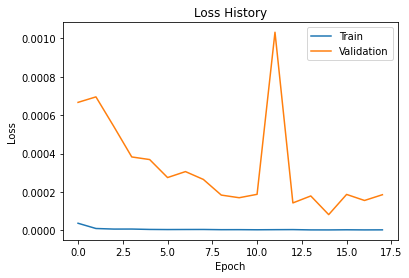

In [ ]:
# Showing history of training
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('Loss History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
# Using inverse scaling for right prediction on test data
y_pred = sc.inverse_transform(model.predict(test_X)) # getting a prediction
test_Y = sc.inverse_transform(test_Y) # Inversion for Y of the test data

In [ ]:
# Getting the required dates for plotting
date_X, date_Y = split_sequences(np.reshape(np.array(date_time[int(n*0.9):]), (-1,1)), num_steps_back)

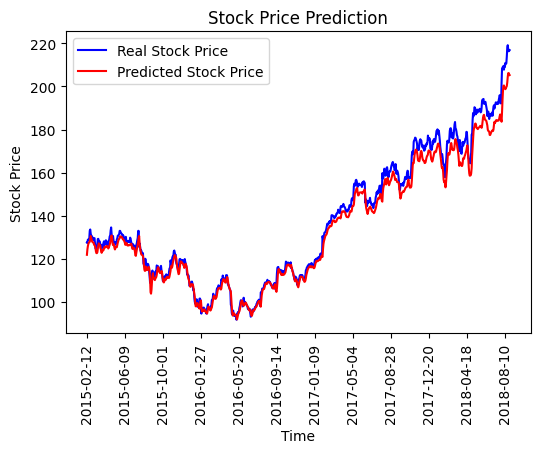

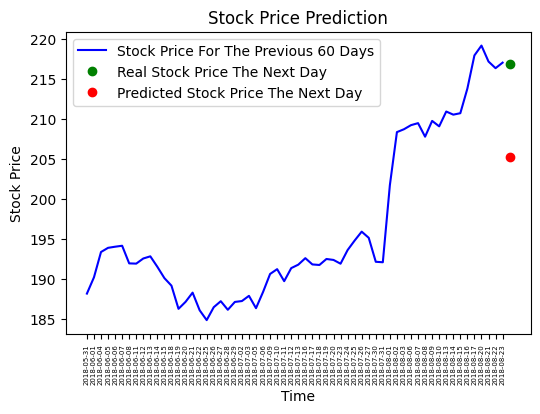

In [ ]:
# Plotting
num_col = 4; # choosing the feature
plt.figure(dpi= 100, facecolor='w', edgecolor='k')
plt.plot(date_Y[:,0], test_Y[:,num_col], color = 'blue', label = 'Real Stock Price')
plt.plot(y_pred[:,num_col], color = 'red', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(np.arange(0, len(date_Y[:,0]), 80), rotation=90);
plt.show()

period = -1 # choosing period position of 60 days
test_period = sc.inverse_transform(test_X[period,:])[:, num_col] # getting the last test 60 days because period = -1
plt.figure(dpi= 100, facecolor='w', edgecolor='k')
plt.plot(date_X[period, :][:, 0], test_period,'b', label = 'Stock Price For The Previous 60 Days')
plt.plot(num_steps_back, test_Y[period, num_col], 'bo', color = 'green' , label = 'Real Stock Price The Next Day')
plt.plot(num_steps_back, y_pred[period, num_col], 'bo', color = 'red', label = 'Predicted Stock Price The Next Day')
plt.title('Stock Price Prediction')
plt.xticks(rotation=90, size = 5)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()